# Fake Disaster Tweet Detection 

>Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).



# Acknowledgements

Some parts of this kernel uses code from: https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud/notebook

## Given data set contains files:
1. train.csv - the training set
2. test.csv - the test set

## Each sample in the train and test set has the following information:
- The text of a tweet
- A keyword from that tweet (this may be blank at some places)
- The location the tweet was sent from (this may also be blank at some places)

## Features in the train data file:
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


## Model used is Multinomial Naive Bayes Classifier.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from plotly import __version__
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
import cufflinks as cf
cf.go_offline()
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string
from unidecode import unidecode
import re
from collections import Counter


from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import joblib
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
!pip install contractions
import contractions 

     |████████████████████████████████| 260 kB 816 kB/s 
     |████████████████████████████████| 321 kB 3.4 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.1-cp37-cp37m-linux_x86_64.whl size=102843 sha256=1a6b0bd6a0d2903d29c23eadd65e4b2bd1cc992c96cbf10d57a44c2cf241d8a7
  Stored in directory: /root/.cache/pip/wheels/fe/ea/e6/38b0d734be6936b783e916a0d8d670313fb1b2f74c5889d4fe
Successfully built pyahocorasick


In [3]:
df_train=pd.read_csv("../input/nlp-getting-started/train.csv")
df_test=pd.read_csv("../input/nlp-getting-started/test.csv")

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_test['text'].head()

0                   Just happened a terrible car crash
1    Heard about #earthquake is different cities, s...
2    there is a forest fire at spot pond, geese are...
3             Apocalypse lighting. #Spokane #wildfires
4        Typhoon Soudelor kills 28 in China and Taiwan
Name: text, dtype: object

In [6]:
df_train[df_train['target']==0]['text']

15                                         What's up man?
16                                          I love fruits
17                                       Summer is lovely
18                                      My car is so fast
19                           What a goooooooaaaaaal!!!!!!
                              ...                        
7581    @engineshed Great atmosphere at the British Li...
7582    Cramer: Iger's 3 words that wrecked Disney's s...
7584    These boxes are ready to explode! Exploding Ki...
7587                                   Sirens everywhere!
7593    I just heard a really loud bang and everyone i...
Name: text, Length: 4342, dtype: object

In [7]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


#  Exploratory Data Analysis

In [8]:
print("train-set shape:- ",df_train.shape)
print("test-set shape:- ",df_test.shape)
print("percent age of null values in location features:-",df_train.location.isnull().sum()/df_train.shape[0]*100)
print("percent age of null values in keyword features:-",df_train.keyword.isnull().sum()/df_train.shape[0]*100)

train-set shape:-  (7613, 5)
test-set shape:-  (3263, 4)
percent age of null values in location features:- 33.27203467752528
percent age of null values in keyword features:- 0.8012610009194797


## 1. Comparing number of Fake tweets and Real tweets

In [9]:
df_train.groupby("target").describe()

id                                                           \
         count         mean          std   min      25%     50%     75%   
target                                                                    
0       4342.0  5276.446338  3157.206802  23.0  2513.25  5243.5  8038.5   
1       3271.0  5661.608071  3097.094809   1.0  3104.50  5676.0  8252.0   

                 
            max  
target           
0       10848.0  
1       10873.0

In [10]:
df_train.target.value_counts().iplot(kind="bar",text=['Fake','Real'],title='Counting number of real disaster (1) tweet or fake disaster (0) tweet')

## 2. Checking for NULL values in Dataset

In [11]:
cf.set_config_file(offline=False, world_readable=True)
missing = df_train.isnull().sum()  
missing[missing>0].iplot(kind='bar',title='Null values present in Dataset', color=['red'])
plt.show()

## 3. Checking for Duplicate values

In [12]:
value=df_train.duplicated().value_counts()
value.iplot(kind='bar',title="finding number of duplicate tweets")

## 4. Comparing the length of Fake and Real tweet

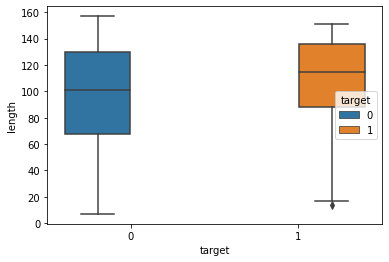

In [13]:
df_train['length']=df_train['text'].apply(len)
sns.boxplot(y='length',data=df_train,hue='target',x=df_train['target'])
plt.show()

In [14]:
df_train[df_train['target']==0].length.value_counts().iplot(kind='bar',title='Calculating length of real tweet (target==0)', color='green')
df_train[df_train['target']==1].length.value_counts().iplot(kind='bar',title='Calculating length of fake tweet (target==1)', color='purple')

## 5. Top 30 Keywords

In [15]:
df_train.keyword.value_counts()[:30].iplot(kind='bar',color='red',title='top 30 keyword')

## 6. Top 30 Locations

In [16]:
df_train.location.value_counts()[:30].iplot(kind='bar',color='red',title='top 30 locations')

# Data-Preprocessing

## 1. Removing Panctuations

In [17]:
df_train['punc_count']=df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
df_train.punc_count.value_counts().iplot(kind='bar',title='Calculating Panctuations in dataset', color='red')

In [18]:
def panctuations(x):
    nonpunc=[]
    for c in x:
        if c not in string.punctuation:
            nonpunc.append(c)
    return "".join(nonpunc)
df_train['text']=df_train['text'].apply(panctuations)
df_test['text']=df_test['text'].apply(panctuations)

## 2.Removing URLs, digits, non-alphabets, _

In [19]:
df_train['urls']=df_train['text'].str.contains('http')
df_train.groupby("urls").sum()['target'].iplot(kind="bar",title='Calculating Urls (True means have HTTP and False means does not have HTTP)')

In [20]:
def clean(x):
    x=re.sub(r"https\S+",r" ",x)
    x=re.sub(r"http\S+",r" ",x)
    x=re.sub(r"\W",r" ",x)
    x=re.sub(r"\d",r" ",x)
    x=re.sub(r"\_",r"",x)
    return x
df_train['text']=df_train['text'].apply(clean)
df_test['text']=df_test['text'].apply(clean)

## 3. Removing Contraction

In [21]:
df_train['text']=[" ".join(map(str,l))for l in df_train['text'].apply(lambda x: (contractions.fix(word) for word in x.split()))]
df_test['text']=[" ".join(map(str,l))for l in df_test['text'].apply(lambda x: (contractions.fix(word) for word in x.split()))]

## 4. tokenization and Removing Stopwords 

In [22]:
from nltk.corpus import stopwords
def stop_word(L):
    L=L.lower()
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    L = tokenizer.tokenize(L)
    stop_w=set(stopwords.words('english'))
    L = " ".join([w for w in L if not w in stop_w]) 
    return L
df_train['text']=df_train['text'].apply(lambda x:stop_word(x))
df_test['text']=df_test['text'].apply(lambda x:stop_word(x))

## 5. Decoding unicode values

In [23]:
def unicode(L):
    L = unidecode(L)
    return L
df_train['text']=df_train['text'].apply(lambda x:unicode(x))
df_test['text']=df_test['text'].apply(lambda x:unicode(x))

## 6. Lemmatization

In [24]:
def lemme(L):
    lemmatizer=nltk.stem.WordNetLemmatizer()
    L=[lemmatizer.lemmatize(word) for word in L.split()]
    L=" ".join(L)
    return L
df_train['text']=df_train['text'].apply(lambda x:lemme(x))
df_test['text']=df_test['text'].apply(lambda x:lemme(x))

## 7. Remove words of length less than 2.

In [25]:
df_train['less_than']=df_train['text'].apply(lambda x: len([w for w in x.split() if len(w)<2]))
df_train.less_than.value_counts().iplot(kind='bar',title='Calculating values less than 2', color='red')

In [26]:
def count(L):
    count=Counter()
    for i in L:
        for word in i.split():
            count[word] +=1
    return count
df_train['less_than_values']=df_train['text'].apply(lambda x: " ".join([w for w in x.split() if len(w)<2]))
count_values=count(df_train['less_than_values'])
list(count_values.items())[:10]

[('u', 639),
 ('r', 31),
 ('k', 27),
 ('w', 63),
 ('n', 32),
 ('p', 32),
 ('a', 18),
 ('g', 21),
 ('h', 12),
 ('v', 35)]

In [27]:
def less_than_2(L):
    L=" ".join([w for w in L.split() if len(w)>1])
    return L
df_train['text']=df_train['text'].apply(lambda x:less_than_2(x))
df_test['text']=df_test['text'].apply(lambda x:less_than_2(x))

# Word-Cloud

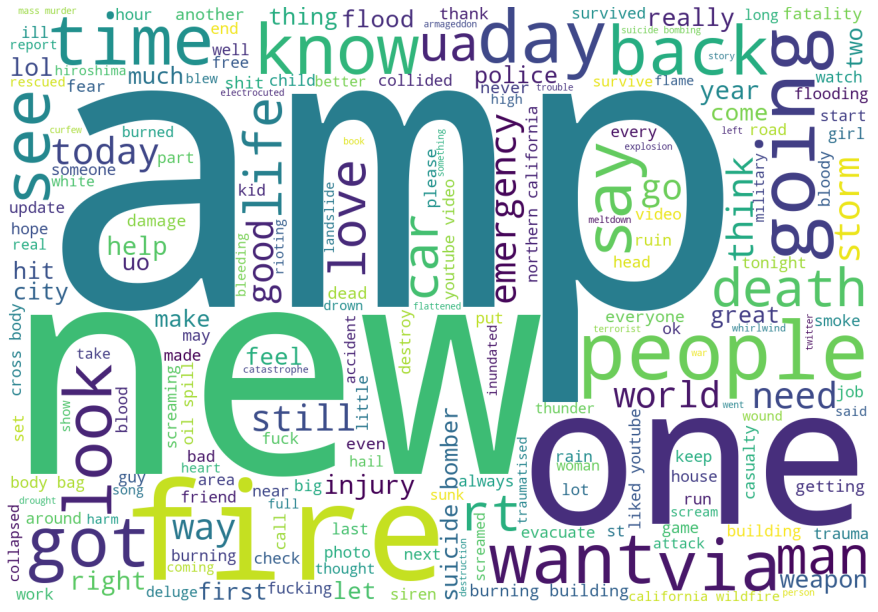

In [28]:
comment_words = '' 
stopwords = set(STOPWORDS) 
for val in df_train['text']:
    tokens = val.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 1300, height = 900, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# CountVectorize

In [29]:
cv=CountVectorizer()
X=cv.fit_transform(df_train['text'])
test=cv.transform(df_test['text'])

In [30]:
y=df_train['target']

# Counter()

In [31]:
def count(L):
    count=Counter()
    for i in L:
        for word in i.split():
            count[word] +=1
    return count
count_values=count(df_train['text'])

In [32]:
list(count_values.items())[:10]

[('deed', 2),
 ('reason', 31),
 ('earthquake', 53),
 ('may', 88),
 ('allah', 9),
 ('forgive', 2),
 ('forest', 66),
 ('fire', 352),
 ('near', 54),
 ('la', 30)]

# Train Test Split

In [33]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, shuffle= True, random_state=33)

# MultinomialNB Model

Test Accuracy using MultiNomial Naive Bayes Classifier:  77.97723292469352
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1310
           1       0.75      0.73      0.74       974

    accuracy                           0.78      2284
   macro avg       0.78      0.77      0.77      2284
weighted avg       0.78      0.78      0.78      2284

[[1070  240]
 [ 263  711]]


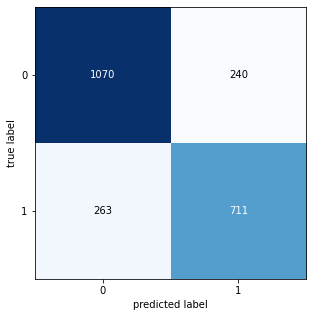

In [34]:
nb=MultinomialNB()
nb.fit(X_train,y_train)
pred=nb.predict(X_test)
print('Test Accuracy using MultiNomial Naive Bayes Classifier: ',accuracy_score(y_test,pred)*100)
print(classification_report(y_test,pred))
print(confusion_matrix(y_test, pred))
CM = confusion_matrix(y_test, pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

# Saving files

In [35]:
# Save the model as a pickle in a file 
joblib.dump(nb, 'tweet.pkl') 

['tweet.pkl']

In [36]:
joblib.dump(cv, 'count.pkl') 

['count.pkl']

# Ploting Curves

In [37]:
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, pred)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.773


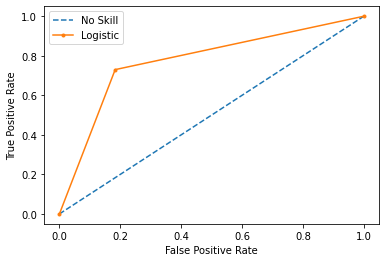

In [38]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, pred)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [39]:
lr_probs = nb.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# predict class values
yhat = nb.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

Logistic: f1=0.739 auc=0.834


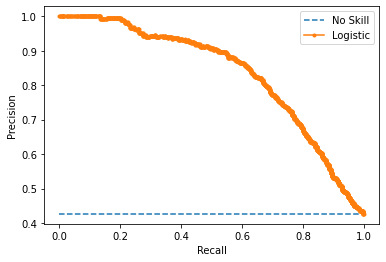

In [40]:
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()